In [1]:
from lib.controller import Controller
from lib.automation import FileDetector
from lib.file.TIF import TIFArrayFile
from lib.analysis.ROI_identification import *
from lib.file.ROI_writer import ROIFileWriter
import time
import os
from lib.utilities import *


In [2]:
data_dir = "C:/Users/jjudge3/Desktop/Data/07-12-22/"
camera_program = 4

slice_target = 1
rec_target = 9

load_dic = False
num_regions_to_export = 5  # max number of regions per record to export to PhotoZ
process_all = False  # overrides slice/rec target to process all files

In [3]:
# read in 8-bit single TIF images to array, apply same cropping/binning
single_images = {}

if load_dic:
    dic_dir = data_dir + "dic/"

    cam_settings = CameraSettings().get_program_settings(camera_program)
    binning = int(cam_settings['height'] / 80)

    for filename in os.listdir(dic_dir):
        if filename.endswith(".tif"):

            tif = TIFArrayFile(filename, dic_dir, cam_settings, binning,
                              show_image=(str(slice_target) in filename and
                                          'e' in filename))

            img = tif.get_data()
            meta = tif.get_meta()
            slic = meta['slice_number']
            loc = meta['location_number']
            img_type = meta['img_type']

            if slic not in single_images:
                single_images[slic] = {}
            if loc not in single_images[slic]:
                single_images[slic][loc] = {}

            single_images[slic][loc][img_type] = img



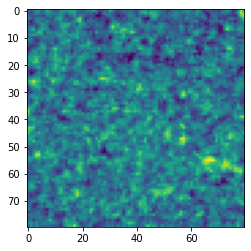

In [4]:
# read in non-normalized maps exported from PhotoZ: 
#  pre-stim SNR, stim SNR, and stim MaxAmp (DAT files)
dat_dir = data_dir + "converted_zda/"
for filename in os.listdir(dat_dir):
    if filename.endswith(".dat") and filename[:3] != "ROI":
        map_type = filename[:3]
        name_parse = filename.split('.')[0][-8:]
        try:
            slic, loc, rec = [int(x) for x in name_parse.split('_')]
        except ValueError:
            continue
        if slic not in single_images:
            single_images[slic] = {}
        if loc not in single_images[slic]:
            single_images[slic][loc] = {}
        if map_type not in single_images[slic][loc]:
            single_images[slic][loc][map_type] = {}
        dat = np.loadtxt(dat_dir + filename,
                         delimiter='\t',
                         usecols=(1,))
        width = int(np.sqrt(dat.shape[0]))
        dat = dat.reshape((width, width))
        if map_type == "SNR" and slic == slice_target and rec == rec_target:
            plt.imshow(dat)
        single_images[slic][loc][map_type][rec] = {
            'data': dat,
            'filename': filename
        }
        

In [5]:
# record stim amplitudes manually
stims = {}
# for 06-21-22
"""
single_images[1][1]['stims'] = [100, 100, 100, 80, 80, 60, 60, 40, 40]
single_images[2][1]['stims'] = [40, 100, 100, 80, 80, 60, 60]
single_images[3][1]['stims'] = [100, 100, 80, 80, 60, 60]
"""

# for 07-12-22
single_images[1][1]['stims'] = [80, 60, 60, 50, 40] + [40 for _ in range(6, 24)]


In [6]:
roi = ROI_Identifier()

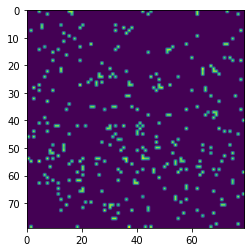

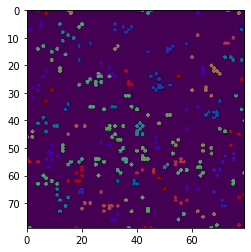

Regions written to: C:/Users/jjudge3/Desktop/Data/07-12-22/converted_zda/ROIs80-SNR01_01_09.dat
5 85 [[3950, 3867], [2862, 3498, 2938], [1547, 1710, 1952, 1871], [5262, 5178, 5258], [4568, 4088, 4327, 4329, 4168, 4169, 4251, 3929]]


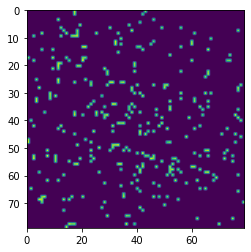

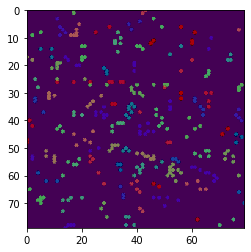

Regions written to: C:/Users/jjudge3/Desktop/Data/07-12-22/converted_zda/ROIs85-SNR01_01_09.dat
5 85 [[4026, 4103], [2932, 2852, 2692], [1618, 1374, 1619, 1455], [5488, 5491, 5486, 5730, 5575], [5028, 4786, 4621, 4868, 4785, 4949, 4620, 4703]]


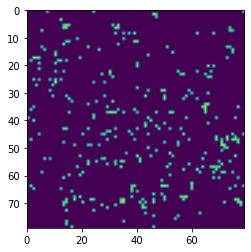

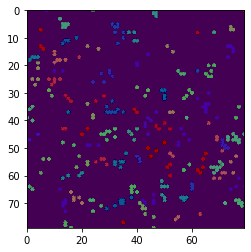

Regions written to: C:/Users/jjudge3/Desktop/Data/07-12-22/converted_zda/ROIs90-SNR01_01_09.dat
5 85 [[7], [3975, 3819, 3895, 3657, 3496], [3942, 3946, 3943], [1114, 1275, 1195, 1113, 1433], [5566, 5646, 5406, 5562, 5643]]


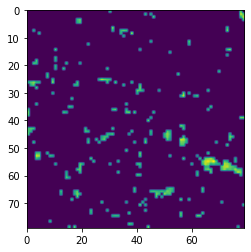

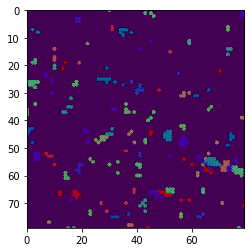

Regions written to: C:/Users/jjudge3/Desktop/Data/07-12-22/converted_zda/ROIs95-SNR01_01_09.dat
5 85 [[3862, 3542, 3541, 3782, 3461], [3817, 3896, 3976, 3816, 3898, 3897, 3818, 3977, 4292, 3737], [1161, 925], [5487, 5407, 5327, 5489, 5326, 5325, 5408], [2409, 2089, 2009, 1847, 1927]]


In [7]:
# single_images structure:
# single_images[slic][loc][image_type] = dic_image 2-D array
#    where image_type is ['e', 'f', 'i'] for electrode, fluorescent, or image
# single_images[slic][loc][map_type][rec] = dat_image 2-D array
#    where map_type is ['Amp', 'SNR', 'Nos'] for amplitude, SNR< or no-stim SNR
# single_images[slic][loc]['stims'] = [stim list indexed by rec #]

percentile_strata = [[80, 85], [85, 90], [90, 95], [95, 100]]

for slic in single_images:
    for loc in single_images[slic]:
        
        # DICs
        #img = single_images[slic][loc]['i']
        #electrode = single_images[slic][loc]['e']
        #fluor = single_images[slic][loc]['f']
        for rec in single_images[slic][loc]['SNR']:
            
            if process_all or (slic == slice_target and rec == rec_target):
                
                snr = single_images[slic][loc]['SNR'][rec]['data']
                w, h = snr.shape
                cluster_strata = []

                for stratum in percentile_strata:
                    low_cutoff, hi_cutoff = stratum

                    sampled_points = roi.generate_points(snr, n_points=100000, 
                                                         percentile_cutoff=low_cutoff,
                                                         upper_cutoff=hi_cutoff)

                    roi.heatmap_of_scatter(sampled_points, w, h) # should look similar
                
                    k = 85

                    if k is None:
                        # use AIC and elbow method, then enter choice of k above
                        roi.find_gmm_cluster_number(sampled_points, k_start=30, k_step=10, k_search=91)
                        break
                    else: # after manually selecting k
                        labels = roi.gaussian_mixture_model(sampled_points, k, show=False)

                        roi.draw_gmm_enclosures(sampled_points, labels, a=0.01, s=10)

                        # print ROIs to a DAT file to be loaded into PhotoZ
                        filename = dat_dir + "ROIs" + str(low_cutoff) + "-" + single_images[slic][loc]['SNR'][rec]['filename']
                        roi_write = ROIFileWriter()
                        regions = roi_write.export_clusters(filename, labels, sampled_points, w, limit=num_regions_to_export)
                        all_regions_by_pixel = roi_write.get_regions_by_pixel()
                        # regions is in format of doubly-nested list of PhotoZ diode numbers
                        print(len(regions), len(all_regions_by_pixel), regions)

                        cluster_objs = []
                        for px_region in all_regions_by_pixel:
                            cluster_objs.append(Cluster(px_region, w))
                            
                        cluster_strata.append(cluster_objs)
                        single_images[slic][loc]['SNR'][rec]['cluster_strata'] = cluster_strata



In [8]:
n_pixel_cutoff = 3  # maximum cluster size allowed
average_snr_cutoff_percentile = 50  # cluster-specific percentile

for slic in single_images:
    for loc in single_images[slic]:
        for rec in single_images[slic][loc]['SNR']:
            
            if process_all or (slic == slice_target and rec == rec_target):
                
                snr = single_images[slic][loc]['SNR'][rec]['data']
                w, h = snr.shape
                cluster_strata = single_images[slic][loc]['SNR'][rec]['cluster_strata']
                
                print("Strata sizes (# clusters):", [len(stratum) for stratum in cluster_strata])
                
                # Split non-contiguous clusters until contiguous
                for stratum in cluster_strata:
                    extra_clusters = []
                    for cluster in stratum:
                        new_clusters = cluster.attempt_split()
                        extra_clusters += new_clusters
                    stratum += extra_clusters
                
                # Filter clusters by size
                for stratum in cluster_strata:
                    for i in range(len(stratum)-1, -1, -1):  # strata 1 is the lower-SNR strata
                        if stratum[i].get_cluster_size() > n_pixel_cutoff:
                            del stratum[i]
                            
                # Filter clusters by avg SNR
                for stratum in cluster_strata:
                    if len(stratum) > 1:
                        stratum_snrs = np.array([cluster.get_cluster_snr(snr) for cluster in stratum])
                        snr_cutoff = np.percentile(stratum_snrs, average_snr_cutoff_percentile)
                        for i in range(len(stratum_snrs)-1, -1, -1):
                            if stratum_snrs[i] < snr_cutoff:
                                del stratum[i]

                # filter adjacent (touching) clusters of different clusters -- remove the lower-SNR one. 
                for i in range(len(cluster_strata)):
                    stratum1 = cluster_strata[i]
                    for j in range(i+1, len(cluster_strata)):
                        stratum2 = cluster_strata[j]
                        for ic_1 in range(len(stratum1)-1, -1, -1):  # stratum 1 is the lower-SNR stratum
                            for c2 in stratum2:
                                if stratum1[ic_1].is_adjacent_to(c2):
                                    del stratum1[ic_1]
                                    break
                                    
                print("Strata sizes (# clusters):", [len(stratum) for stratum in cluster_strata])


Strata sizes (# clusters): [85, 85, 85, 85]
Strata sizes (# clusters): [0, 0, 0, 73]


Regions written to: C:/Users/jjudge3/Desktop/Data/07-12-22/converted_zda/ROIs95-SNR01_01_09.dat


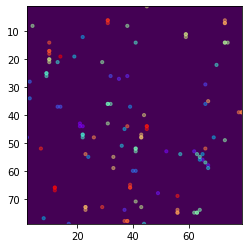

In [11]:
for slic in single_images:
    for loc in single_images[slic]:
        for rec in single_images[slic][loc]['SNR']:
            
            if process_all or (slic == slice_target and rec == rec_target):
                
                snr = single_images[slic][loc]['SNR'][rec]['data']
                w, h = snr.shape
                cluster_strata = single_images[slic][loc]['SNR'][rec]['cluster_strata']
                                                    
                # consolidate strata and show all surviving ROIs
                plt.clf()
                j_label = 0
                for i in range(len(cluster_strata)):
                    stratum = cluster_strata[i]
                    if len(stratum) > 0:
                        pixels = []
                        labels = []
                        for c in stratum:
                            new_pixels = c.get_pixels()
                            pixels += new_pixels
                            labels += [j_label for _ in range(len(new_pixels))]
                            j_label += 1
                        pixels = np.array(pixels)
                        roi.draw_gmm_enclosures(pixels, labels, a=0.5, s=10, show=False, plot_sample_heatmap=False)
                        filename = dat_dir + "ROIs-highest" + "-" + single_images[slic][loc]['SNR'][rec]['filename']
                        roi_write = ROIFileWriter()
                        
                        # TO DO: export only the highest SNR clusters.
                        
                        regions = roi_write.export_clusters(filename, labels, pixels, w, limit=num_regions_to_export)
                plt.show()

In [10]:
# find relevant signal statistic for time course
